<a href="https://colab.research.google.com/github/min02yam/wether/blob/main/Kriging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.라이브러리 로드

In [4]:
#install.packages(c("sp", "gstat"))
library(sp)
library(gstat)

In [5]:
suppressPackageStartupMessages({
  library(dplyr) # for "glimpse"
  library(ggplot2)
  library(scales) # for "comma"
  library(magrittr)
})

In [6]:
data(meuse)
glimpse(meuse)

Rows: 155
Columns: 14
$ x       <dbl> 181072, 181025, 181165, 181298, 181307, 181390, 181165, 181027…
$ y       <dbl> 333611, 333558, 333537, 333484, 333330, 333260, 333370, 333363…
$ cadmium <dbl> 11.7, 8.6, 6.5, 2.6, 2.8, 3.0, 3.2, 2.8, 2.4, 1.6, 1.4, 1.8, 1…
$ copper  <dbl> 85, 81, 68, 81, 48, 61, 31, 29, 37, 24, 25, 25, 93, 31, 27, 86…
$ lead    <dbl> 299, 277, 199, 116, 117, 137, 132, 150, 133, 80, 86, 97, 285, …
$ zinc    <dbl> 1022, 1141, 640, 257, 269, 281, 346, 406, 347, 183, 189, 251, …
$ elev    <dbl> 7.909, 6.983, 7.800, 7.655, 7.480, 7.791, 8.217, 8.490, 8.668,…
$ dist    <dbl> 0.00135803, 0.01222430, 0.10302900, 0.19009400, 0.27709000, 0.…
$ om      <dbl> 13.6, 14.0, 13.0, 8.0, 8.7, 7.8, 9.2, 9.5, 10.6, 6.3, 6.4, 9.0…
$ ffreq   <fct> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,…
$ soil    <fct> 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,…
$ lime    <fct> 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1,…
$ landuse <fct> Ah

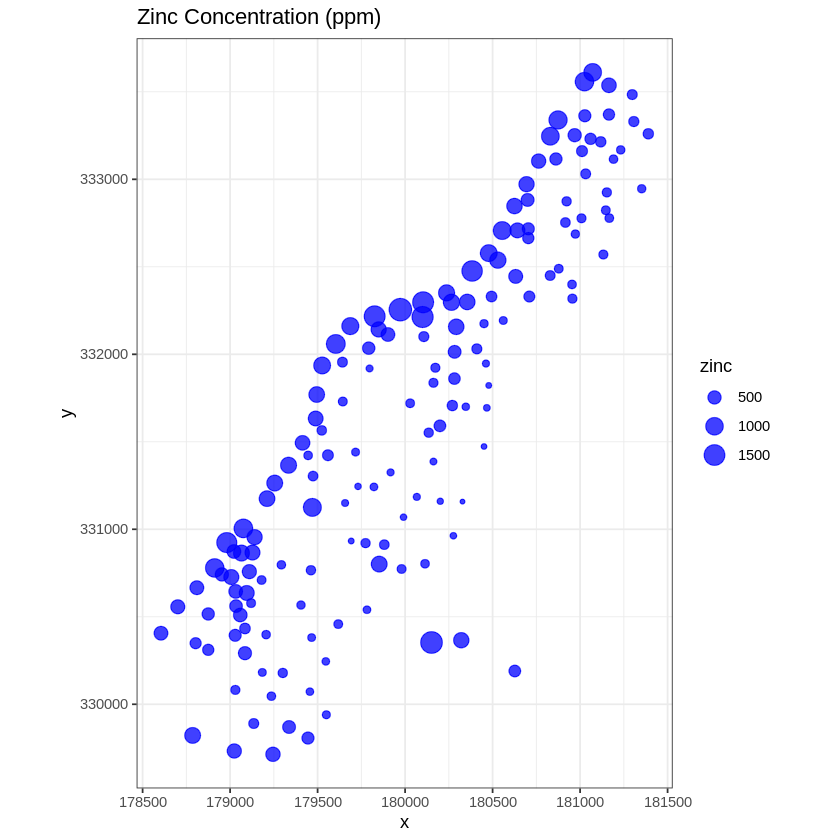

In [7]:
meuse %>% as.data.frame %>% 
  ggplot(aes(x, y)) + geom_point(aes(size=zinc), color="blue", alpha=3/4) + 
  ggtitle("Zinc Concentration (ppm)") + coord_equal() + theme_bw()

# Implementation

## 1) Converting to an SPDF

In [8]:
class(meuse)
str(meuse)

[1] "data.frame"

'data.frame':	155 obs. of  14 variables:
 $ x      : num  181072 181025 181165 181298 181307 ...
 $ y      : num  333611 333558 333537 333484 333330 ...
 $ cadmium: num  11.7 8.6 6.5 2.6 2.8 3 3.2 2.8 2.4 1.6 ...
 $ copper : num  85 81 68 81 48 61 31 29 37 24 ...
 $ lead   : num  299 277 199 116 117 137 132 150 133 80 ...
 $ zinc   : num  1022 1141 640 257 269 ...
 $ elev   : num  7.91 6.98 7.8 7.66 7.48 ...
 $ dist   : num  0.00136 0.01222 0.10303 0.19009 0.27709 ...
 $ om     : num  13.6 14 13 8 8.7 7.8 9.2 9.5 10.6 6.3 ...
 $ ffreq  : Factor w/ 3 levels "1","2","3": 1 1 1 1 1 1 1 1 1 1 ...
 $ soil   : Factor w/ 3 levels "1","2","3": 1 1 1 2 2 2 2 1 1 2 ...
 $ lime   : Factor w/ 2 levels "0","1": 2 2 2 1 1 1 1 1 1 1 ...
 $ landuse: Factor w/ 15 levels "Aa","Ab","Ag",..: 4 4 4 11 4 11 4 2 2 15 ...
 $ dist.m : num  50 30 150 270 380 470 240 120 240 420 ...


In [9]:
coordinates(meuse) <- ~ x + y

In [10]:
class(meuse)
str(meuse)

[1] "SpatialPointsDataFrame"
attr(,"package")
[1] "sp"

Formal class 'SpatialPointsDataFrame' [package "sp"] with 5 slots
  ..@ data       :'data.frame':	155 obs. of  12 variables:
  .. ..$ cadmium: num [1:155] 11.7 8.6 6.5 2.6 2.8 3 3.2 2.8 2.4 1.6 ...
  .. ..$ copper : num [1:155] 85 81 68 81 48 61 31 29 37 24 ...
  .. ..$ lead   : num [1:155] 299 277 199 116 117 137 132 150 133 80 ...
  .. ..$ zinc   : num [1:155] 1022 1141 640 257 269 ...
  .. ..$ elev   : num [1:155] 7.91 6.98 7.8 7.66 7.48 ...
  .. ..$ dist   : num [1:155] 0.00136 0.01222 0.10303 0.19009 0.27709 ...
  .. ..$ om     : num [1:155] 13.6 14 13 8 8.7 7.8 9.2 9.5 10.6 6.3 ...
  .. ..$ ffreq  : Factor w/ 3 levels "1","2","3": 1 1 1 1 1 1 1 1 1 1 ...
  .. ..$ soil   : Factor w/ 3 levels "1","2","3": 1 1 1 2 2 2 2 1 1 2 ...
  .. ..$ lime   : Factor w/ 2 levels "0","1": 2 2 2 1 1 1 1 1 1 1 ...
  .. ..$ landuse: Factor w/ 15 levels "Aa","Ab","Ag",..: 4 4 4 11 4 11 4 2 2 15 ...
  .. ..$ dist.m : num [1:155] 50 30 150 270 380 470 240 120 240 420 ...
  ..@ coords.nrs : int [1:2] 1 

In [11]:
bbox(meuse)
meuse@bbox

,min,max
x,178605,181390
y,329714,333611


,min,max
x,178605,181390
y,329714,333611


In [13]:
coordinates(meuse) 
meuse@coords

,x,y
1,181072,333611
2,181025,333558
3,181165,333537
4,181298,333484
5,181307,333330
6,181390,333260
7,181165,333370
8,181027,333363
9,181060,333231
10,181232,333168


,x,y
1,181072,333611
2,181025,333558
3,181165,333537
4,181298,333484
5,181307,333330
6,181390,333260
7,181165,333370
8,181027,333363
9,181060,333231
10,181232,333168


## 2) Fitting a variogram

In [15]:
lzn.vgm <- variogram(log(zinc)~1, meuse) # calculates sample variogram values 
lzn.fit <- fit.variogram(lzn.vgm, model=vgm(1, "Sph", 900, 1)) # fit model

http://127.0.0.1:27851/library/gstat/html/vgm.html

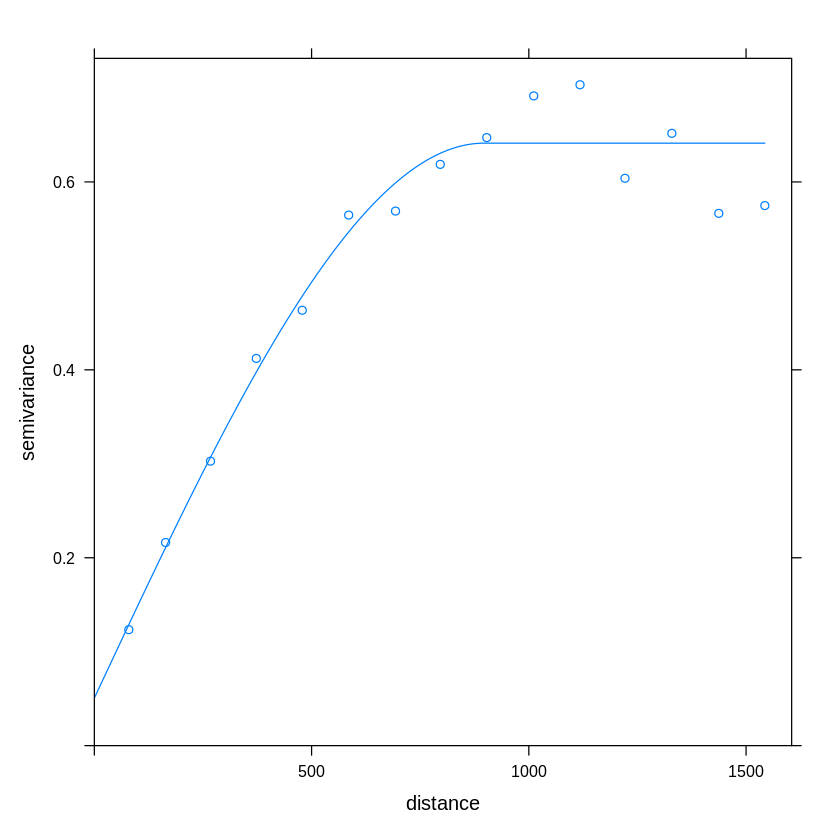

In [16]:
plot(lzn.vgm, lzn.fit) # plot the sample values, along with the fit model

## 3) Performing Kriging

In [17]:
# load spatial domain to interpolate over
data("meuse.grid")

In [20]:
meuse.grid %>% head

,x,y,part.a,part.b,dist,soil,ffreq
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
1,181180,333740,1,0,0.0000000,1,1
2,181140,333700,1,0,0.0000000,1,1
3,181180,333700,1,0,0.0122243,1,1
4,181220,333700,1,0,0.0434678,1,1
5,181100,333660,1,0,0.0000000,1,1
6,181140,333660,1,0,0.0122243,1,1


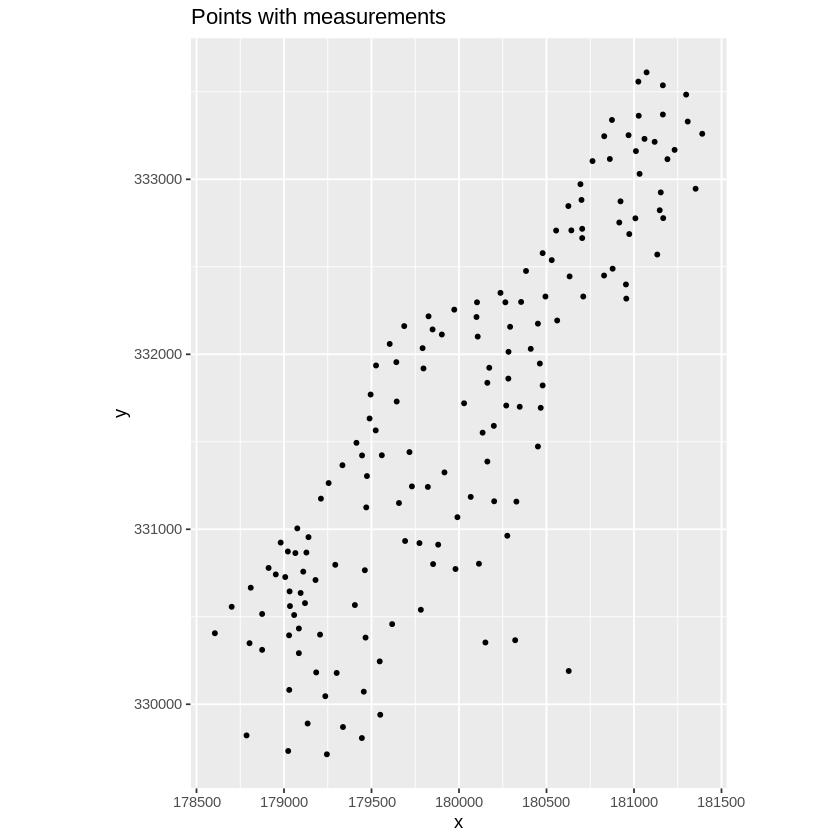

In [22]:
# to compare, recall the bubble plot above; those points were what there were values for. this is much more sparse
plot1 <- meuse %>% as.data.frame %>%
  ggplot(aes(x, y)) + geom_point(size=1) + coord_equal() + 
  ggtitle("Points with measurements")
plot1

In [ ]:


# this is clearly gridded over the region of interest
plot2 <- meuse.grid %>% as.data.frame %>%
  ggplot(aes(x, y)) + geom_point(size=1) + coord_equal() + 
  ggtitle("Points at which to estimate")

library(gridExtra)
grid.arrange(plot1, plot2, ncol = 2)

https://rpubs.com/nabilabd/118172   <BR>
https://www.aspexit.com/variogram-and-spatial-autocorrelation/